# Portfolio Workflow

In [1]:
import logging
import logging.config

logging.config.fileConfig('./config/logging.ini')
logger = logging.getLogger('GenerateBacktest')

import configparser
from platform import python_version
from pathlib import Path

# Set the import path for the project tools directiory
import sys
# insert at position 1 in the path, as 0 is the path of this file.
sys.path.insert(1, 'tools')

# Project imports
import importlib
import trading_factors_yahoo as alpha_factors
importlib.reload(alpha_factors)
import utils
importlib.reload(utils)
import nonoverlapping_estimator as ai_estimator
importlib.reload(ai_estimator)

import time
from datetime import datetime
import os
import pandas as pd
import numpy as np
import math
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pickle

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20, 8)

logger.info(f'Python version: {python_version()}')
logger.info(f'Pandas version: {pd.__version__}')

2022-05-18 21:12:49,764|numexpr.utils|INFO|NumExpr defaulting to 4 threads.
Sci-Kit version: 0.24.1
Sci-Kit version: 0.24.1
2022-05-18 21:12:53,312|GenerateBacktest|INFO|Python version: 3.8.8
2022-05-18 21:12:53,313|GenerateBacktest|INFO|Pandas version: 1.3.5


In [2]:
config = configparser.ConfigParser()
config.read('./config/config.ini')
default_config = config['BackTest']

# Price History data and Alphs Factors

In [18]:
price_histories_file_name = default_config['DataDirectory'] + '/' + default_config['PriceHistoriesFileName']
ai_alpha_factors_file_name = default_config['DataDirectory'] + '/' + default_config['AIAlphaFileName']
beta_factors_file_name = default_config["DataDirectory"] + '/' + default_config['BetaFactorsFileName']


logger.info(f'PRICE_HISTORIES_FILE|{price_histories_file_name}...')
price_histories = pd.read_csv(price_histories_file_name, header=[0, 1], index_col=[0], parse_dates=True, low_memory=False)
pricing = price_histories.Close
adv = alpha_factors.AverageDollarVolume(price_histories, 5).factor_data
print(f'You have {len(pricing.columns)} stocks from picing')

logger.info(f'ALPHA_VECTORS_FILE|{ai_alpha_factors_file_name}...')
alpha_vectors = pd.read_csv(ai_alpha_factors_file_name, parse_dates=['Date']).set_index(['Date']).sort_index()
logger.info(f'ALPHA_VECTORS_STOCKS|{len(alpha_vectors.columns)}')

logger.info(f'BEATA_FACTORS_FILE|{beta_factors_file_name}...')
with open(beta_factors_file_name, 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    daily_betas = pickle.load(f)
logger.info(f'DAILY_BETAS|{len(daily_betas)}')

risk_cap = float(default_config['risk_cap'])
weights_max = float(default_config['weights_max'])
weights_min = float(default_config['weights_min'])

logger.info(f'OPT|risk_cap|{risk_cap}')
logger.info(f'OPT|weights_max|{weights_max}')
logger.info(f'OPT|weights_min|{weights_min}')

2022-05-18 22:25:06,006|GenerateBacktest|INFO|PRICE_HISTORIES_FILE|./data/price_histories_yahoo.csv...
You have 501 stocks from picing
2022-05-18 22:25:07,153|GenerateBacktest|INFO|ALPHA_VECTORS_FILE|./data/pre_backtest_alpha_vectors.csv...
2022-05-18 22:25:07,334|GenerateBacktest|INFO|ALPHA_VECTORS_STOCKS|501
2022-05-18 22:25:07,350|GenerateBacktest|INFO|BEATA_FACTORS_FILE|./data/daily_beta.pickle...
2022-05-18 22:25:09,132|GenerateBacktest|INFO|DAILY_BETAS|1009
2022-05-18 22:25:09,132|GenerateBacktest|INFO|OPT|risk_cap|0.25
2022-05-18 22:25:09,132|GenerateBacktest|INFO|OPT|weights_max|0.15
2022-05-18 22:25:09,132|GenerateBacktest|INFO|OPT|weights_min|0.0


Symbols,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,ADP,...,WMB,WTW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
count,1.256000e+03,1.256000e+03,1.256000e+03,1.256000e+03,1.256000e+03,1.256000e+03,1.256000e+03,1.256000e+03,1.256000e+03,1.256000e+03,...,1.256000e+03,1.256000e+03,1.256000e+03,1.256000e+03,1.256000e+03,1.256000e+03,1.256000e+03,1.256000e+03,1.256000e+03,1.256000e+03
mean,4.523046e+08,7.035898e+07,4.927213e+08,6.537820e+08,1.307347e+08,4.431250e+08,5.120840e+08,1.475661e+08,9.921294e+08,3.130035e+08,...,1.900838e+08,1.718096e+08,3.394452e+08,1.782627e+08,8.208762e+07,1.761879e+08,1.045057e+08,1.680777e+08,9.397131e+07,2.596087e+08
std,1.491700e+08,3.645664e+07,2.219586e+08,3.027871e+08,1.072030e+08,2.168586e+08,2.572676e+08,6.731468e+07,5.263519e+08,1.213993e+08,...,8.158498e+07,1.120601e+08,2.010784e+08,6.129112e+07,3.158899e+07,5.685004e+07,6.968300e+07,5.978122e+07,3.275533e+07,1.045979e+08
min,2.050927e+08,2.103315e+07,1.642059e+08,1.781226e+08,2.833287e+07,1.362834e+08,1.595900e+08,5.395350e+07,1.855747e+08,1.136762e+08,...,6.525235e+07,4.592830e+07,1.245866e+08,7.048471e+07,2.827137e+07,7.110099e+07,1.422527e+07,6.060292e+07,3.141276e+07,7.289097e+07
25%,3.527843e+08,4.934849e+07,3.376236e+08,4.450187e+08,7.302627e+07,2.899563e+08,3.617642e+08,1.087092e+08,6.199819e+08,2.347398e+08,...,1.404681e+08,9.553538e+07,2.339754e+08,1.369672e+08,6.085451e+07,1.354775e+08,6.184728e+07,1.226822e+08,7.117515e+07,1.877142e+08
50%,4.205056e+08,6.287997e+07,4.539117e+08,6.004657e+08,1.039962e+08,3.838425e+08,4.657193e+08,1.313473e+08,8.906654e+08,2.904021e+08,...,1.766152e+08,1.352829e+08,2.941963e+08,1.660463e+08,7.579192e+07,1.646232e+08,9.128461e+07,1.552567e+08,8.887743e+07,2.361024e+08
75%,5.083706e+08,8.252672e+07,5.855010e+08,7.773141e+08,1.566218e+08,5.230546e+08,5.966414e+08,1.662348e+08,1.236619e+09,3.604103e+08,...,2.221871e+08,2.129883e+08,3.921360e+08,2.058366e+08,9.691978e+07,2.052701e+08,1.327447e+08,2.005077e+08,1.111093e+08,3.103478e+08
max,1.172199e+09,4.131768e+08,1.600343e+09,2.275964e+09,1.378530e+09,1.495323e+09,3.438463e+09,5.618686e+08,3.906131e+09,1.294699e+09,...,1.031980e+09,9.961335e+08,2.639174e+09,4.977518e+08,2.189954e+08,5.062460e+08,7.465640e+08,4.116908e+08,2.403232e+08,7.723389e+08


In [20]:
get_lambda(adv)

Symbols,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,ADP,...,WMB,WTW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2017-05-15,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,...,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05
2017-05-16,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,...,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05
2017-05-17,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,...,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05
2017-05-18,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,...,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05
2017-05-19,3.540335e-10,2.467470e-09,4.400050e-10,2.361880e-10,2.151084e-09,4.267166e-10,2.460757e-10,1.000500e-09,2.173368e-10,4.232422e-10,...,8.310029e-10,5.905958e-10,3.802650e-10,9.879910e-10,1.860294e-09,5.619409e-10,3.058303e-09,4.234223e-10,7.853042e-10,8.015954e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-09,2.048780e-10,1.637602e-09,1.654796e-10,1.033793e-10,1.020747e-09,1.476192e-10,1.397067e-10,3.293272e-10,7.443585e-11,2.319227e-10,...,2.752595e-10,6.409603e-10,4.672977e-10,3.468937e-10,7.230900e-10,4.825922e-10,4.575930e-10,4.175821e-10,1.139772e-09,1.940100e-10
2022-05-10,1.929470e-10,1.460047e-09,1.570575e-10,1.018967e-10,9.792241e-10,1.429371e-10,1.546227e-10,3.302601e-10,6.314178e-11,2.213429e-10,...,2.658110e-10,6.632786e-10,3.855857e-10,3.565782e-10,7.292305e-10,5.017171e-10,4.553419e-10,4.834512e-10,1.155523e-09,1.876798e-10
2022-05-11,2.062737e-10,1.511887e-09,1.530354e-10,1.023639e-10,9.874438e-10,1.399147e-10,1.615772e-10,3.320372e-10,6.282543e-11,2.149846e-10,...,2.917165e-10,6.774775e-10,3.482548e-10,3.525118e-10,8.854496e-10,5.153402e-10,4.758756e-10,5.450090e-10,1.257959e-09,1.970135e-10


In [17]:
def get_lambda(average_dollar_volume):
    adv = average_dollar_volume.replace(np.nan, 1.0e4)
    adv = adv.replace(0.0, 1.0e4)
    return 0.1 / adv

def get_total_transaction_costs(h0, h_star, lambda):
    return np.dot( (h_star - h0) ** 2, lambda)

# Back test AI Alpha and Daily Betas to produce optimal weights

2022-05-18 22:37:32,679|GenerateBacktest|INFO|OPT|2021-05-17 00:00:00|2022-05-06 00:00:00


Dates:   0%|          | 0/50 [00:00<?, ? Portfolio Optimization/s]

C:\Users\HP-Z440\anaconda3\envs\ml4t\lib\site-packages\cvxpy\problems\problem.py:1267: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


2022-05-18 22:55:37,286|GenerateBacktest|INFO|OPT_PORT_RETURN|8.63%
2022-05-18 22:55:37,286|GenerateBacktest|INFO|OPT|PROCEED|8.63%


<AxesSubplot:>

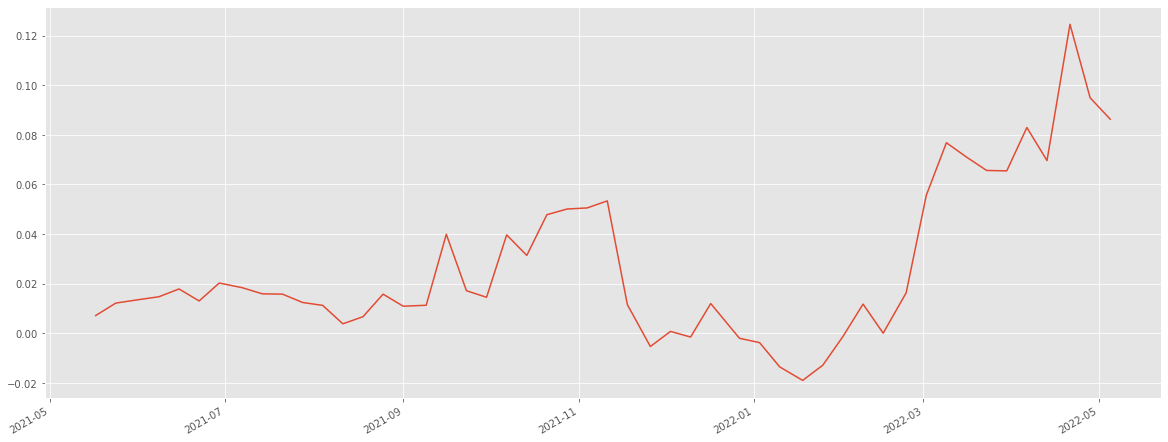

In [31]:
import portfolio_optimizer
from portfolio_optimizer import OptimalHoldings
importlib.reload(portfolio_optimizer)

returns = alpha_factors.FactorReturns(price_histories).factor_data
dlyreturn_n_days_delay = 5
delayed_returns = returns[-252:].shift(-dlyreturn_n_days_delay).dropna()
start_date = list(delayed_returns.index)[0]
end_date = list(delayed_returns.index)[-1]
logger.info(f'OPT|{start_date}|{end_date}')
tc_lambda = get_lambda(adv)

current_holdings = pd.Series(np.zeros(len(delayed_returns.columns)), index=delayed_returns.columns)

min_viable_port_return = float(default_config['min_viable_port_return'])
opt_date_returns = {}
opt_date_tc = {}
for opt_date in tqdm(delayed_returns.index.to_list()[-252::dlyreturn_n_days_delay], desc='Dates', unit=' Portfolio Optimization'):
    alpha_vector = pd.DataFrame(alpha_vectors.loc[opt_date])
    risk_model = daily_betas[opt_date.strftime('%m/%d/%Y')]
    est_return = delayed_returns.loc[opt_date]
    optimal_weights = OptimalHoldings(risk_cap=risk_cap,weights_max=weights_max, weights_min=weights_min).find(alpha_vector, risk_model.factor_betas_, risk_model.factor_cov_matrix_, risk_model.idiosyncratic_var_vector_)
    new_holdings = optimal_weights['optimalWeights']
    opt_date_returns[opt_date] = (new_holdings * est_return).sum()
    # trading costs
    opt_date_tc[opt_date] = get_total_transaction_costs(current_holdings, new_holdings, tc_lambda.loc[opt_date])
    current_holdings = new_holdings

port_return = round(np.sum(list(opt_date_returns.values())) * 100, 2)
logger.info(f'OPT_PORT_RETURN|{port_return}%')
if port_return >= min_viable_port_return:
    logger.info(f'OPT|PROCEED|{port_return}%')
else:
    logger.warn(f'OPT|STOP|{port_return}')
    raise RuntimeError(f'Backtest indicates this strategy needs more work! ({port_return})') from None
    
pd.Series(opt_date_returns).cumsum().plot()

In [32]:
tc_ser = pd.Series(opt_date_tc)
re_ser = pd.Series(opt_date_returns)
net_ret = re_ser - tc_ser

<AxesSubplot:>

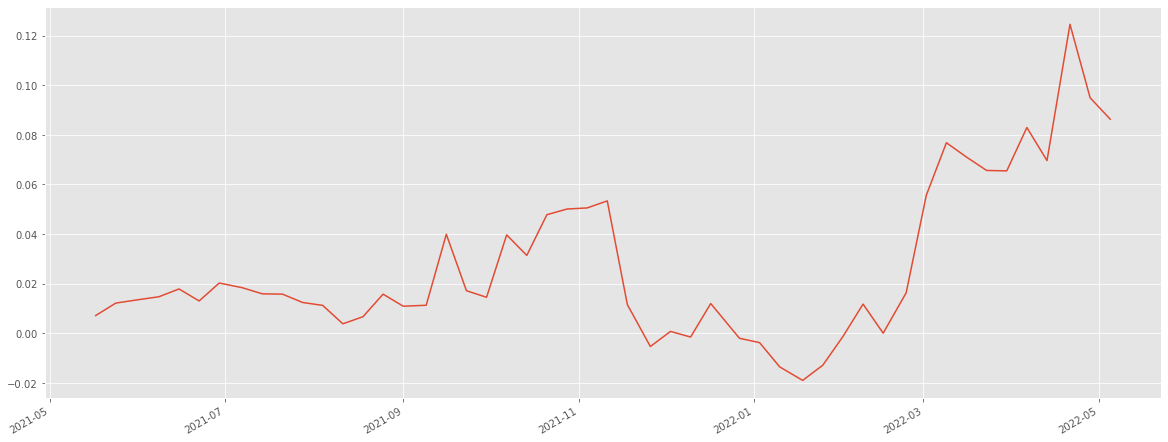

In [33]:
net_ret.cumsum().plot()

In [42]:
np.sum(net_ret)

0.08629147127788431

In [43]:
np.sum(re_ser)

0.08629148093379056

## TODO:

- For go forward situations, save all the information to be used to put in buy/sell orders